In [25]:
import refinitiv.data as rd
import numpy as np
import pandas as pd
import matplotlib as plt
import warnings
import plotly.graph_objects as go
import time
warnings.filterwarnings("ignore")
%matplotlib inline

In [26]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x7f7010bf06d0 {name='codebook'}>

In [27]:
# which index is used as a basis of comparison
index = '.SPX'
# what is the time range for the backtesting 
start_year = 2020
end_year = 2022
# what is the company's  minimum ESG Score (0-100) for the high ESG subset
ESG_score_threshold_upper = 70

ESG_score_threshold_lower = 30

In [53]:
def synchronize_start_date(df, start_date='2019-01-01'):
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
    df = df[df['Date'] >= pd.to_datetime(start_date)]  # Filter data to start from the given start_date
    return df

In [54]:
sp = rd.get_data(
    index, 
    fields=['TR.PriceClose.date', 'TR.PriceClose'],
    parameters={
        'SDate': '{}-01-01'.format(start_year),
        'EDate': '{}-01-01'.format(end_year),
        'Frq': 'm'  # Daily frequency
    }
)

In [55]:
sp['PctChange'] = sp['Price Close'].pct_change() * 100  # Monthly percentage change (returns)

# Handle missing values in the 'PctChange' column (fill NaNs with 0)
sp['PctChange'] = sp['PctChange'].fillna(0)

# Calculate monthly volatility (standard deviation of monthly returns)
monthly_volatility = sp['PctChange'].std()  # Standard deviation of percentage changes (monthly volatility)

# Calculate rolling volatility (e.g., 12-month rolling standard deviation)
sp['RollingVolatility'] = sp['PctChange'].rolling(window=12).std() * (252 ** 0.5)  # Annualized volatility based on monthly data

# Print the monthly volatility
print(f"Monthly Volatility (S&P 500): {monthly_volatility:.2f}%")

# Show the first few rows of the DataFrame with new columns
print(sp[['Price Close', 'PctChange', 'RollingVolatility']].head())

Monthly Volatility (S&P 500): 5.63%
   Price Close  PctChange  RollingVolatility
0      3225.52        0.0                NaN
1      2954.22  -8.411047                NaN
2      2584.59 -12.511932                NaN
3      2912.43   12.68441                NaN
4      3044.31   4.528178                NaN


In [56]:
def getSubset(dFrame, low_high):
    # filter out the companies with low ESG score at the begining year
    if low_high == "low":
        dFrame = dFrame.loc[
            (dFrame['ESG Combined Score'] < ESG_score_threshold_lower) 
        ]
    elif low_high == "high":
        dFrame = dFrame.loc[
            (dFrame['ESG Combined Score'] > ESG_score_threshold_upper)
        ]
    return dFrame['Instrument'].tolist()

In [71]:
def getDataForYear(year, low_high):
    print(f'Getting data for: {year}')
    # get index constituents at the begining year
    start_date = '{}-01-01'.format(year)
    end_date = '{}-01-01'.format(year + 1)
    df = rd.get_data('{}{}({}-01-01)'.format('0#', index, year), fields=['TR.TRESGCScore'], parameters={'SDate': start_date, 'Period': 'FY0'})
    # filter out the instruments based on ESG ratings
    subset = getSubset(df, low_high)
    # get the performance data for this subset
    df2 = rd.get_data(subset, fields=['TR.PriceClose.date', 'TR.PriceClose'], parameters={'SDate': start_date, 'EDate': end_date, 'Frq': 'm'})
    df2 = df2.dropna()
    # consolidate the price data for instruments
    alphaList = []
    ser = df2['Date'].value_counts()
    for x in ser[ser > 5].index:
        ser = df2.loc[df2['Date'] == x].sum(numeric_only=True)
        alphaList.append({'Date': x, 'Price Close': ser['Price Close']})
    return pd.DataFrame(alphaList)

In [72]:
sp['Price Close'].dtype

Float64Dtype()

In [73]:
def calculate_volatility_and_pct_change(df):
    # Ensure 'Price Close' is numeric, coerce any non-numeric values to NaN
    df['Price Close'] = pd.to_numeric(df['Price Close'], errors='coerce')

    # Drop rows where 'Price Close' is NaN
    df = df.dropna(subset=['Price Close'])  # This removes rows where 'Price Close' is NaN
    
    # Calculate percentage change for 'Price Close' (monthly percentage change)
    df['PctChange'] = df['Price Close'].pct_change() * 100  # In percentage terms
    
    # Drop rows where 'PctChange' is NaN (from the first percentage change)
    df = df.dropna(subset=['PctChange'])  # This ensures no NaN values in 'PctChange' column
    
    # Calculate 12-month rolling volatility (annualized)
    df['RollingVolatility'] = df['PctChange'].rolling(window=12).std() * (252 ** 0.5)  # Annualized volatility based on monthly data
    
    return df

In [74]:
df_high = pd.DataFrame()
df_low = pd.DataFrame()

In [76]:
for x in range(start_year, end_year + 1):
    ret_high = getDataForYear(x, "high")
    df_high = pd.concat([df_high, ret_high])
    time.sleep(3)  # Prevent rate-limiting issues

Getting data for: 2020
Getting data for: 2021
Getting data for: 2022


In [77]:
for x in range(start_year, end_year + 1):
    ret_low = getDataForYear(x, "low")
    df_low = pd.concat([df_low, ret_low])
    time.sleep(3)  # Prevent rate-limiting issues

Getting data for: 2020
Getting data for: 2021
Getting data for: 2022


In [78]:
df_high = df_high.sort_values(by=['Date']).reset_index(drop=True)
df_low = df_low.sort_values(by=['Date']).reset_index(drop=True)

In [79]:
df_high = calculate_volatility_and_pct_change(df_high)
df_low = calculate_volatility_and_pct_change(df_low)

In [80]:
sp = calculate_volatility_and_pct_change(sp)

In [81]:
df_high.to_csv('Combined_ESG_Score_high70.csv', index=False)
df_low.to_csv('Combined_ESG_Score_low30.csv', index=False)

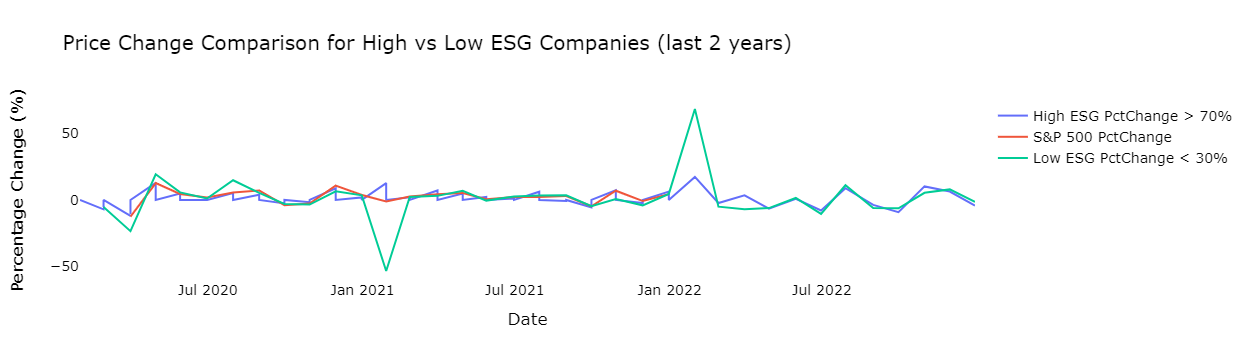

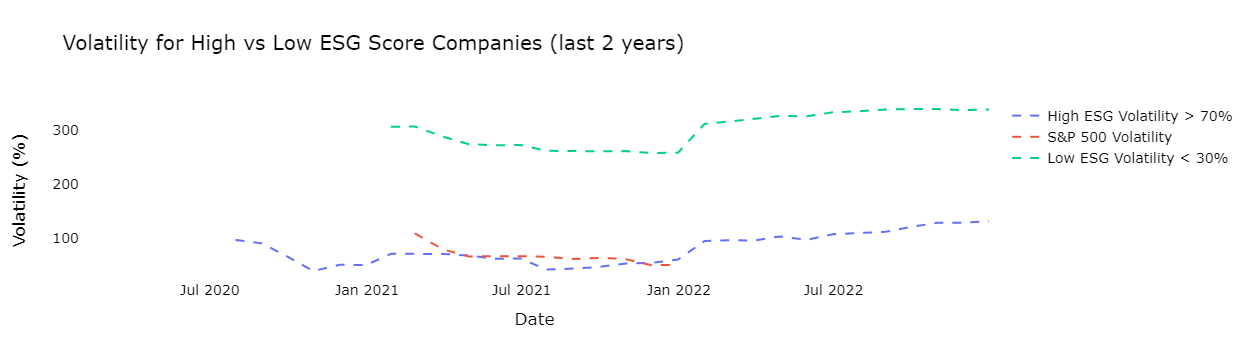

In [82]:
pct_change_res = [
    go.Scatter(x=df_high['Date'], y=df_high['PctChange'], name=f'High ESG PctChange > {ESG_score_threshold_upper}%', mode='lines'),
    go.Scatter(x=sp['Date'], y=sp['PctChange'], name='S&P 500 PctChange', mode='lines'),
    go.Scatter(x=df_low['Date'], y=df_low['PctChange'], name=f'Low ESG PctChange < {ESG_score_threshold_lower}%', mode='lines')
]

# Layout for the percentage change plot
pct_change_layout = {
    'title': f'Price Change Comparison for High vs Low ESG Companies (last {end_year - start_year} years)',
    'xaxis': {'title': 'Date'},
    'yaxis': {'title': 'Percentage Change (%)'},
    'font': {'size': 14, 'color': 'black'},
    'plot_bgcolor': 'white',
    'paper_bgcolor': 'white'
}

# Create the figure for percentage change graph
fig_pct_change = go.Figure(data=pct_change_res)
fig_pct_change.update_layout(pct_change_layout)

# Show the percentage change plot
fig_pct_change.show()


# --- Separate the Volatility Graph ---
# Create traces for volatility
volatility_res = [
    go.Scatter(x=df_high['Date'], y=df_high['RollingVolatility'], name=f'High ESG Volatility > {ESG_score_threshold_upper}%', mode='lines', line=dict(dash='dash')),
    go.Scatter(x=sp['Date'], y=sp['RollingVolatility'], name='S&P 500 Volatility', mode='lines', line=dict(dash='dash')),
    go.Scatter(x=df_low['Date'], y=df_low['RollingVolatility'], name=f'Low ESG Volatility < {ESG_score_threshold_lower}%', mode='lines', line=dict(dash='dash'))
]

# Layout for the volatility plot
volatility_layout = {
    'title': f'Volatility for High vs Low ESG Score Companies (last {end_year - start_year} years)',
    'xaxis': {'title': 'Date'},
    'yaxis': {'title': 'Volatility (%)'},
    'font': {'size': 14, 'color': 'black'},
    'plot_bgcolor': 'white',
    'paper_bgcolor': 'white'
}

# Create the figure for volatility graph
fig_volatility = go.Figure(data=volatility_res)
fig_volatility.update_layout(volatility_layout)

# Show the volatility plot
fig_volatility.show()